In [1]:
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.chemkin import loadChemkinFile
import os

In [2]:
# chemkin model name
mech = 'surm002'

In [3]:
path = os.path.abspath('../')
mechPath = path + '/data/' + mech
chemkinPath= mechPath + '/chem.inp'
dictionaryPath = mechPath + '/species_dictionary.txt'

model = CoreEdgeReactionModel()
model.core.species, model.core.reactions = loadChemkinFile(chemkinPath,dictionaryPath)

In [4]:
# generate paris for reactions that don't have flux pairs
for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()

## Create networkx Graph

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from extractInfoFromckcsv import getConcentrationDictFromCKCSV, getROPFromCKCSV, getFluxGraphEdgesDict
from rmgpy.chemkin import getSpeciesIdentifier
from IPython.display import display
import numpy as np
%matplotlib inline

### s1: prepare a dict for graph edges

In [6]:
ckcsvPath= mechPath + '/CKSoln_sample1_400C.ckcsv'
firstColDict, spc_mf_dict = getConcentrationDictFromCKCSV(ckcsvPath)

first_col_dict, spc_total_rop_dict, spc_rop_dict = getROPFromCKCSV(ckcsvPath)

In [7]:
graph_edges_dict = getFluxGraphEdgesDict(spc_rop_dict, model.core.reactions)

In [8]:
graph_edges_dict_simple = {}
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    graph_edges_dict_simple[(node1, node2)] = graph_edges_dict[pair]

### s2: create DiGraph()

In [9]:
time_investigated = 1 # hour
timepoint_index = (np.abs(firstColDict['Time_(sec)']-time_investigated*3600)).argmin()

In [33]:
G = nx.DiGraph()
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    e_rawdata = graph_edges_dict[pair]
    total_flux = 0
    for rxn in e_rawdata:
        total_flux += e_rawdata[rxn][timepoint_index]
    if total_flux >= 0:
        G.add_edge(node2, node1, {"total_flux":total_flux})
    else:
        G.add_edge(node1, node2, {"total_flux":-total_flux})

### s3: find paths

In [43]:
paths = list(nx.all_simple_paths(G, source="PDD(5)", target="toluene(1)", cutoff=10))

#### sort out most sginificant path

In [46]:
path_fluxes = []
for i, path in enumerate(paths):
#     print i, path
    path_steps = len(path) - 1
    fluxes = [G[path[step]][path[step+1]]['total_flux'] for step in range(path_steps) ]
    path_fluxes.append(min(fluxes))
sorted_path_fluxes = sorted(path_fluxes)
print sorted_path_fluxes[-1], path_fluxes.index(sorted_path_fluxes[-1])

1.68399862267e-08 23688


#### visualize the path of interest



**********Step0: PDD(5) --> RAD3(153): 1.68399862267e-08*************


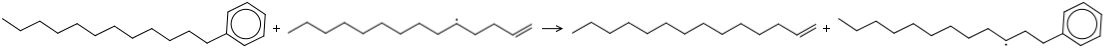

rxn#2322(1/57 H_Abs): PDD(5) + C=CCC[CH]CCCCCCCCC(284) <=> C=CCCCCCCCCCCCC(293) + RAD3(153)


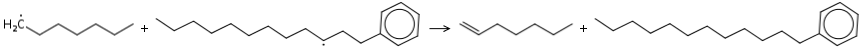

rxn#1189(1/24 Disp): HEPTYL(187) + RAD3(153) <=> C7ene(176) + PDD(5)


**********Step1: RAD3(153) --> C7H7(6): 2.910247e-08*************


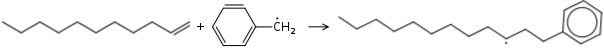

rxn#1019: C11ene(180) + [CH2]C1C=CC=CC=1(6) <=> RAD3(153)


**********Step2: C7H7(6) --> toluene(1): 1.0383784592e-07*************


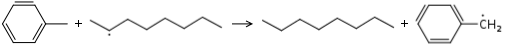

rxn#152(1/73 H_Abs): toluene(1) + C[CH]CCCCCC(9) <=> octane(2) + [CH2]C1C=CC=CC=1(6)


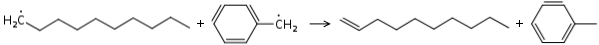

rxn#879(1/24 Disp): DECYL(190) + [CH2]C1C=CC=CC=1(6) <=> C10ene(179) + toluene(1)


In [47]:
path = paths[23688]
path_steps = len(path) - 1
for step in range(path_steps):
    step_pair = (path[step], path[step+1])
    h_abs_rxns = []
    disp_rxns = []
    
    print "\n"
    print "**********Step{0}: {1} --> {2}: {3}*************".\
    format(step, step_pair[0], step_pair[1], G[step_pair[0]][step_pair[1]]['total_flux'])
    if step_pair not in graph_edges_dict_simple:
        step_pair = (step_pair[1], step_pair[0])
                
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print "rxn#{0}: ".format(rxn.index) + str(rxn)
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])

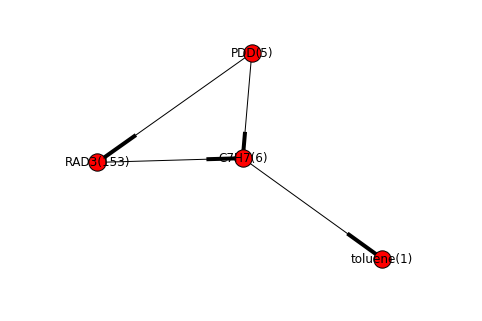

In [49]:
newG = G.subgraph(paths[23688])
nx.draw(newG, with_labels=True)